# Assignment 4 DAL

## Utkarsh Pathak (DA24S011)

Consider a SporadicClassifier that returns a random label in {True, False} for any test input that’s fed to it. This classifier does not require any training! Hope, that was already obvious to you. Implement this SporadicClassifier as a Python class by extending the BaseEstimator class of sklearn, so that you have mandatory methods such as fit(X, y) and predict(X) are implemented. As your guess, the fit() method would be a dummy ‘pass’, but the predict() method would return True or False randomly.

Let’s measure the label distribution (prior probability) of the predictions made by
SporadicClassifier. As you guessed, the label distribution is dependent on the random
generator, which typically could be one of {Normal, Bernoulli or Uniform} distributions. As a part of
Task 1, you are to implement all the above three generators (using libraries). You may choose the
generator type while instantiating the classifier object. Moreover, Bernoulli requires ‘p’ as a
parameter representing the probability of “True”. Likewise, the normal and uniform distributions
require a threshold to convert the discrete samples into Booleans. You may assume that the
threshold is in [0,1] range. Typically, you will instantiate as
SporadicClassifier(method=’bernoulli’, p=0.5). The expectation is a line-plot with
the x-axis represent the p in [0,1] in steps of 0.1 and the y-axis representing the Pr(True). Your plot
will have 3 such lines representing 3 different random generators.

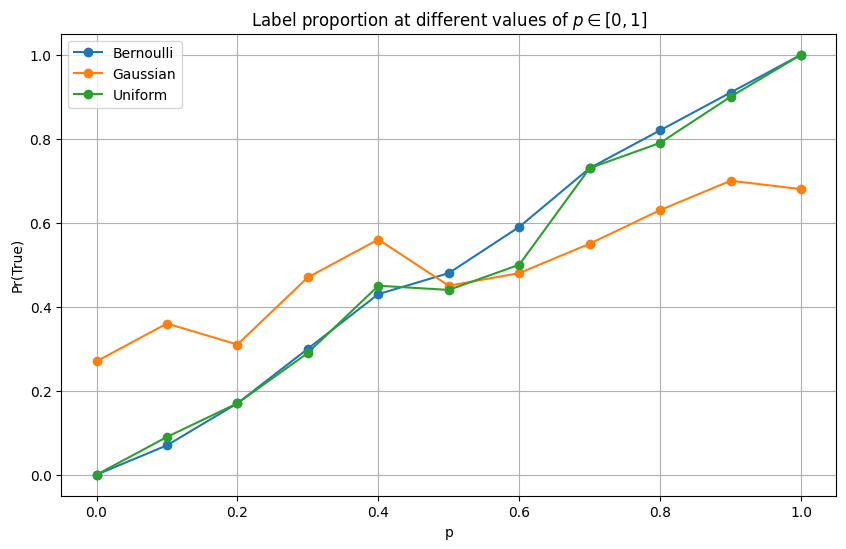

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from scipy.stats import bernoulli
from collections import Counter

class SporadicClassifier(BaseEstimator):
    def __init__(self, p=0.5, method='uniform_random'):
        # Ensure 'p' is within the [0, 1] range; otherwise, default to 0.5
        self.p = 0.5 if p < 0.0 or p > 1.0 else p
        # Ensure method is one of the allowed values; otherwise, default to 'uniform_random'
        self.method = method if method in ["uniform_random", "bernoulli", "gaussian"] else "uniform_random"

    def fit(self, X, y=None):
        # No training required for this classifier
        pass

    def predict(self, X):
        if self.method == "gaussian":
            # Gaussian (normal) distribution centered around 0.5
            return (0.5 + np.random.randn(len(X))) < self.p
        elif self.method == "bernoulli":
            # Bernoulli distribution with parameter p
            return bernoulli.rvs(self.p, size=len(X)).astype(bool)
        else:
            # Uniform distribution
            return np.random.rand(len(X)) < self.p

# Create a dataset of size 100 instances
X = np.random.rand(100)

# Reusable function to compute prior probabilities
def compute_prior(y):
    # Count the occurrences of each class label
    c = Counter(y)
    # Convert counts to proportions
    props = {i[0]: i[1] / len(y) for i in c.items()}
    # Ensure both True and False are present in the dictionary
    if True not in props:
        props[True] = 0.0
    if False not in props:
        props[False] = 0.0
    return props

# Compute the label distribution for different configurations
p_vals = np.arange(0., 1.1, 0.1)  # Range from 0 to 1 in steps of 0.1
b_vals, g_vals, u_vals = [], [], []

for p in p_vals:
    # Bernoulli random sample generator
    cla = SporadicClassifier(p=p, method='bernoulli')
    y = cla.predict(X)
    props = compute_prior(y)
    b_vals.append(props[True])

    # Gaussian random sample generator
    cla = SporadicClassifier(p=p, method='gaussian')
    y = cla.predict(X)
    props = compute_prior(y)
    g_vals.append(props[True])

    # Uniform random sample generator
    cla = SporadicClassifier(p=p, method='uniform_random')
    y = cla.predict(X)
    props = compute_prior(y)
    u_vals.append(props[True])

# Plot the trends for comparison
plt.figure(figsize=(10, 6))
plt.plot(p_vals, b_vals, marker='o')
plt.plot(p_vals, g_vals, marker='o')
plt.plot(p_vals, u_vals, marker='o')
plt.xlabel('p')
plt.ylabel('Pr(True)')
plt.title('Label proportion at different values of $p \\in [0,1]$')
plt.legend(['Bernoulli', 'Gaussian', 'Uniform'], loc='upper left')
plt.grid(True)
plt.show()


Consider the IRIS dataset, but convert the 3-class dataset into a binary class dataset by choosing the
majority class as say class True and the remaining two classes as class False. Now, using the
bernoulli version of the SporadicClassifier, make the prediction of binary IRIS dataset.
1. Report the label prior of the binary IRIS dataset.
2. Compute the Precision, Recall, F1 of the prediction at different choice of p-values in [0,1] in
steps of 0.1 and plot the P, R, C as line plots.
3. Using the P & R values, plot PRC.
4. Using TPR and FPR, plot RoC.
5. Report the AUPRC and AURoC

---



Label Prior: {0: 0.6666666666666666, 1: 0.3333333333333333}


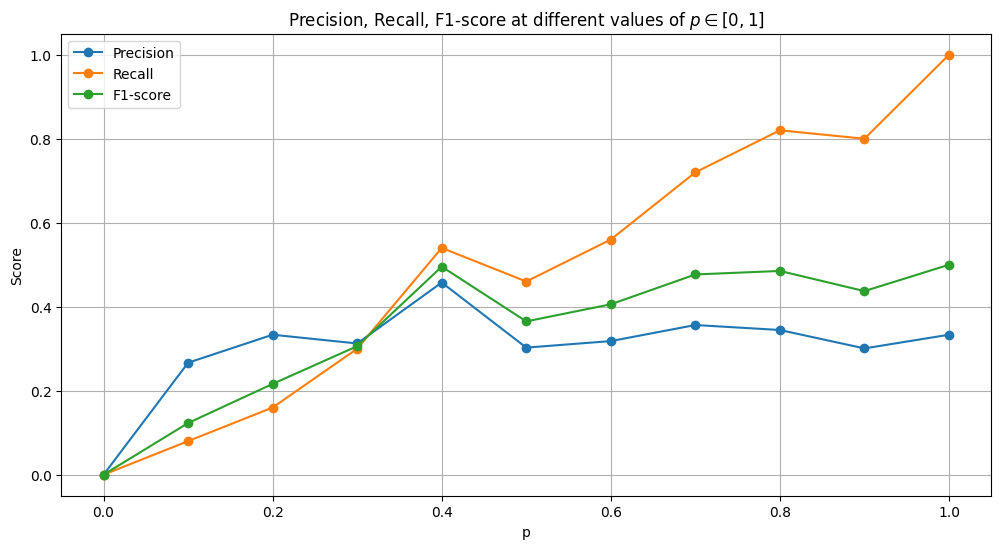

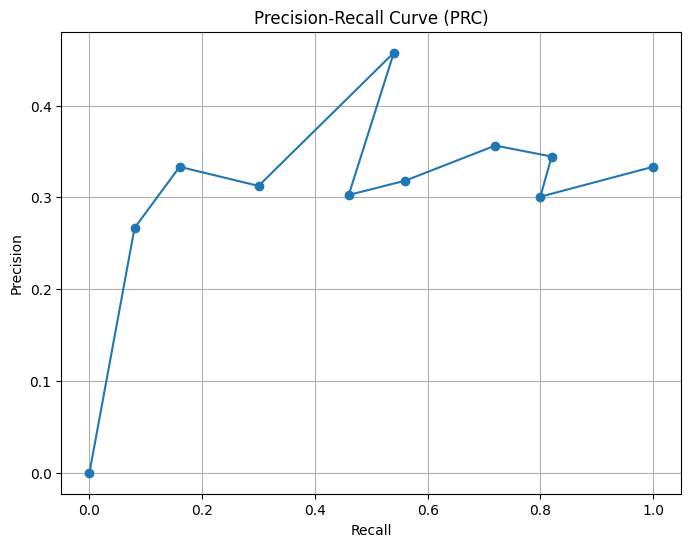

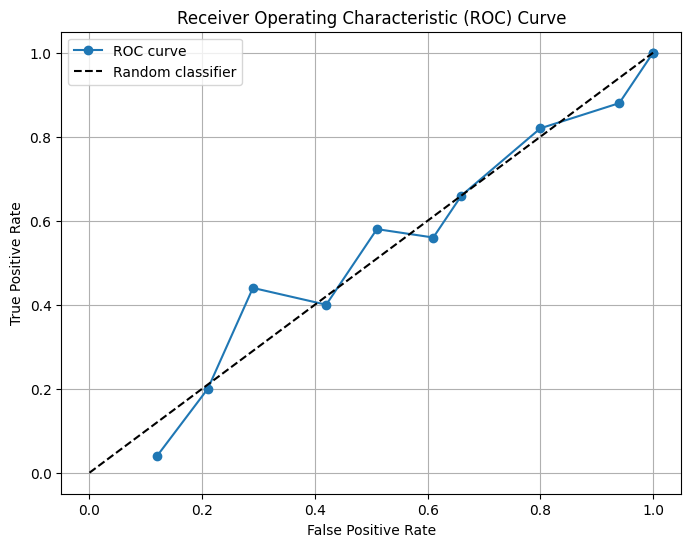

Area Under the ROC Curve (AUC): 0.502


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.base import BaseEstimator
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.stats import bernoulli
from collections import Counter

# 1. Load the IRIS dataset and convert it to a binary class dataset
def load_binary_iris():
    iris = load_iris()
    X, y = iris.data, iris.target
    # Majority class is class 0 (Setosa), let's make it True (1)
    y_binary = (y == 0).astype(int)  # Setosa is True (1), others are False (0)
    return X, y_binary

class SporadicClassifier(BaseEstimator):
    def __init__(self, p=0.5, method='bernoulli'):
        """Initialize the classifier with a probability 'p' and a method."""
        self.p = 0.5 if p < 0.0 or p > 1.0 else p
        self.method = method if method in ["uniform_random", "bernoulli", "gaussian"] else "uniform_random"

    def fit(self, X, y=None):
        """Dummy fit method as no training is needed."""
        pass

    def predict(self, X):
        """Predict labels using Bernoulli random generator."""
        if self.method == "bernoulli":
            return bernoulli.rvs(self.p, size=len(X)).astype(bool)
        else:
            raise ValueError("Unsupported method. Please use 'bernoulli'.")

def compute_prior(y):
    """Compute and return the prior probabilities of the binary labels."""
    c = Counter(y)
    props = {i: c[i] / len(y) for i in [0, 1]}  # Correctly count both 0 and 1 labels
    return props

# 2. Compute Precision, Recall, F1-score for different p-values
def compute_metrics_at_p_values(X, y_true, p_vals):
    precisions, recalls, f1s = [], [], []

    for p in p_vals:
        clf = SporadicClassifier(p=p, method='bernoulli')
        y_pred = clf.predict(X)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    return precisions, recalls, f1s

# 3. Plot Precision, Recall, F1-score at different p-values
def plot_prc_f1(p_vals, precisions, recalls, f1s):
    plt.figure(figsize=(12, 6))
    plt.plot(p_vals, precisions, marker='o', label='Precision')
    plt.plot(p_vals, recalls, marker='o', label='Recall')
    plt.plot(p_vals, f1s, marker='o', label='F1-score')
    plt.xlabel('p')
    plt.ylabel('Score')
    plt.title('Precision, Recall, F1-score at different values of $p \\in [0,1]$')
    plt.legend()
    plt.grid(True)
    plt.show()

# 4. Plot PRC curve using Precision and Recall values
def plot_prc_curve(precisions, recalls):
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (PRC)')
    plt.grid(True)
    plt.show()

# 5. Plot ROC curve using TPR and FPR
def plot_roc_curve(X, y_true, p_vals):
    """Plot ROC curve and compute AUC score."""
    tprs, fprs = [], []

    for p in p_vals:
        clf = SporadicClassifier(p=p, method='bernoulli')
        y_pred = clf.predict(X)
        # Compute FPR and TPR for different thresholds
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        fprs.append(fpr[1])
        tprs.append(tpr[1])

    # Sort FPR and TPR values for AUC calculation
    fprs, tprs = zip(*sorted(zip(fprs, tprs)))

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fprs, tprs, marker='o', label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Calculate Area Under the ROC Curve (AUC)
    auc_score = auc(fprs, tprs)
    return auc_score

# Main execution
X, y_binary = load_binary_iris()

# Report the label prior of the binary IRIS dataset
priors = compute_prior(y_binary)
print(f"Label Prior: {priors}")

# Define p-values
p_vals = np.arange(0., 1.1, 0.1)

# Compute metrics
precisions, recalls, f1s = compute_metrics_at_p_values(X, y_binary, p_vals)

# Plot Precision, Recall, F1-score
plot_prc_f1(p_vals, precisions, recalls, f1s)

# Plot PRC Curve
plot_prc_curve(precisions, recalls)

# Plot ROC Curve and calculate AUC
auc_score = plot_roc_curve(X, y_binary, p_vals)
print(f"Area Under the ROC Curve (AUC): {auc_score:.3f}")


Generate the visualization of the decision boundaries induced by sporadicClassifier at
different values of p in [0, 1] in steps of 0.25 for all the three random generators.

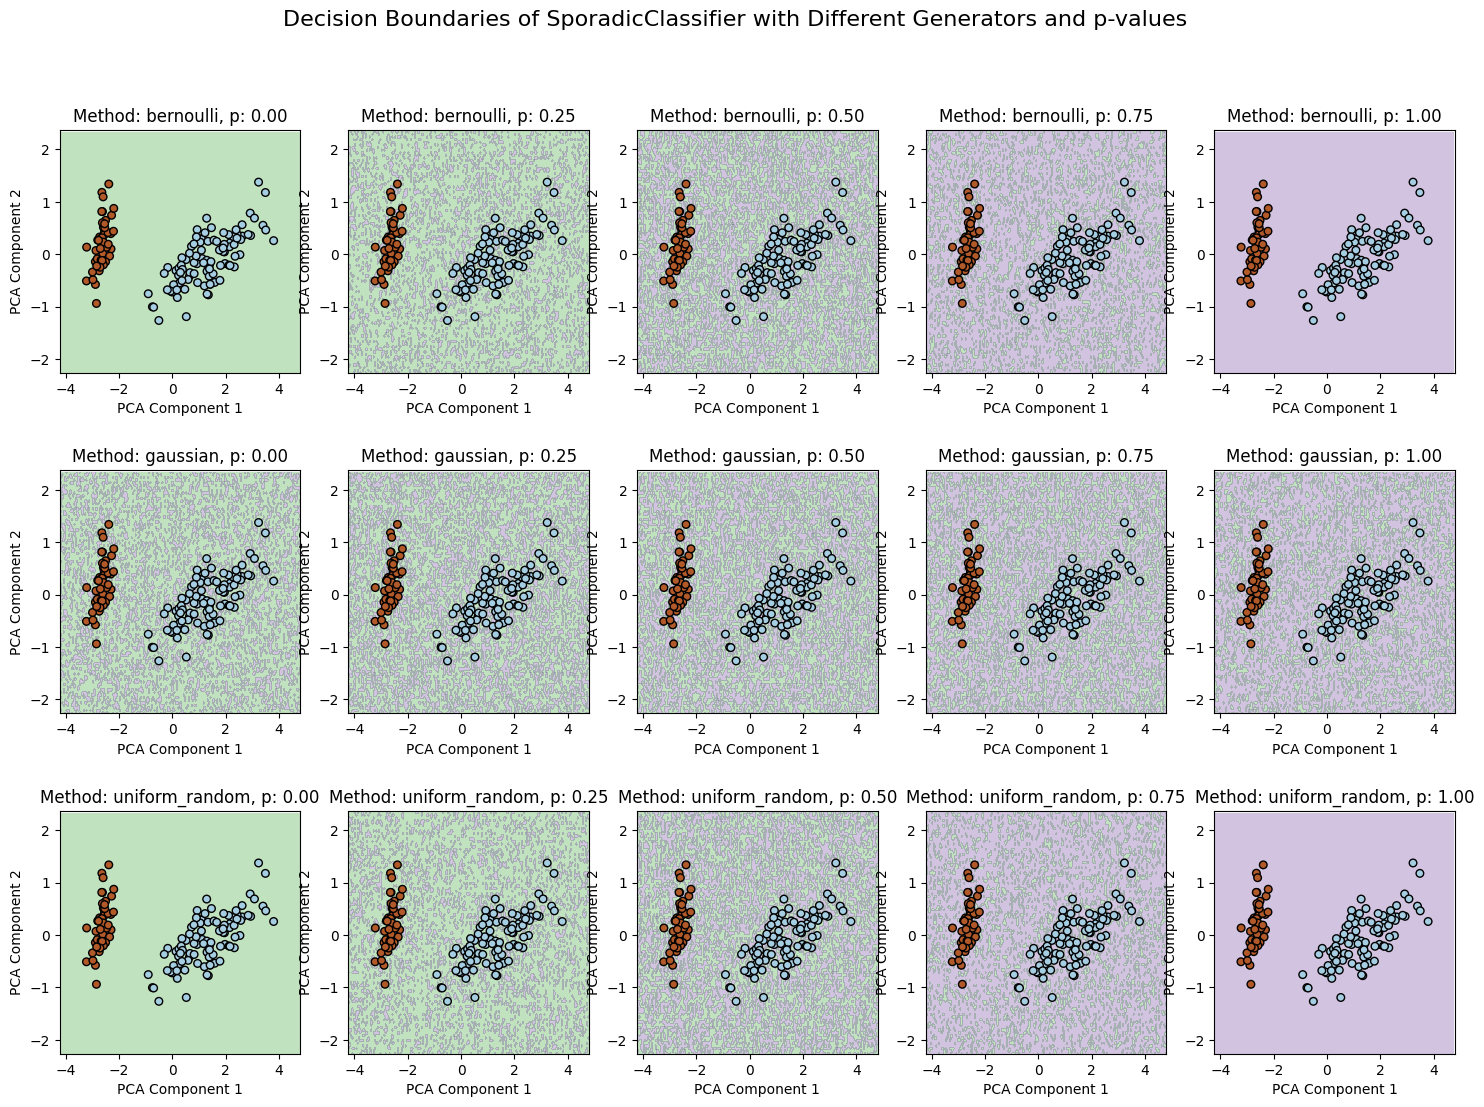

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from scipy.stats import bernoulli

class SporadicClassifier(BaseEstimator):
    def __init__(self, p=0.5, method='bernoulli'):
        """Initialize the classifier with a probability 'p' and a method."""
        self.p = 0.5 if p < 0.0 or p > 1.0 else p
        self.method = method if method in ["uniform_random", "bernoulli", "gaussian"] else "uniform_random"

    def fit(self, X, y=None):
        """Dummy fit method as no training is needed."""
        pass

    def predict(self, X):
        """Predict labels using different random generators."""
        if self.method == "bernoulli":
            return bernoulli.rvs(self.p, size=len(X)).astype(bool)
        elif self.method == "gaussian":
            return (0.5 + np.random.randn(len(X))) < self.p
        else:  # Uniform Random
            return np.random.rand(len(X)) < self.p

# Function to plot decision boundaries
def plot_decision_boundary(clf, X, y, ax, p, method):
    """Plot decision boundary for a classifier on a 2D plane."""
    # Create a meshgrid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))

    # Predict on meshgrid points
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and data points
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o', s=30, cmap=plt.cm.Paired)
    ax.set_title(f"Method: {method}, p: {p:.2f}")
    ax.set_xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    ax.set_ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

# Load IRIS dataset and project onto 2D space using PCA
iris = load_iris()
# iris = load_iris()
X, y = iris.data, iris.target
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Convert to binary problem (majority class vs. rest)
y_binary = (y == 0).astype(int)  # Setosa is True (1), others are False (0)

# Define values of p and methods
p_vals = np.arange(0., 1.1, 0.25)
methods = ['bernoulli', 'gaussian', 'uniform_random']

# Create a plot grid
fig, axs = plt.subplots(len(methods), len(p_vals), figsize=(18, 12))
plt.subplots_adjust(hspace=0.4)

# Plot decision boundaries for each method and value of p
for i, method in enumerate(methods):
    for j, p in enumerate(p_vals):
        clf = SporadicClassifier(p=p, method=method)
        clf.fit(X_pca, y_binary)  # Fit method is a pass, but kept for consistency
        plot_decision_boundary(clf, X_pca, y_binary, axs[i, j], p, method)

plt.suptitle('Decision Boundaries of SporadicClassifier with Different Generators and p-values', fontsize=16)
plt.show()


We can extend our the code  to compute performance metrics (Precision, Recall, F1-score, AUPRC, AURoC) for each method over multiple trials and then average the results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: Undefin

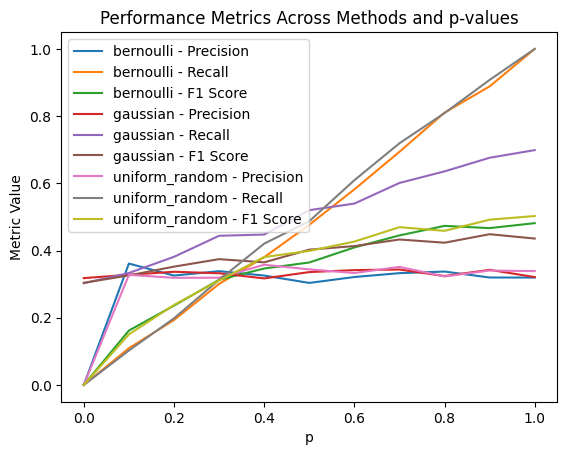

In [5]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
import numpy as np

def evaluate_method(X, y, method, p_vals, trials=50):
    """Evaluate a method over multiple trials and average the performance metrics."""
    avg_metrics = {'precision': [], 'recall': [], 'f1': [], 'auc': [], 'prc_auc': []}

    for p in p_vals:
        precision_vals, recall_vals, f1_vals, auc_vals, prc_auc_vals = [], [], [], [], []

        for _ in range(trials):
            clf = SporadicClassifier(p=p, method=method)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            # Compute metrics
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
            auc = roc_auc_score(y_test, y_pred)
            prc_auc = average_precision_score(y_test, y_pred)

            precision_vals.append(precision)
            recall_vals.append(recall)
            f1_vals.append(f1)
            auc_vals.append(auc)
            prc_auc_vals.append(prc_auc)

        # Average metrics for current p
        avg_metrics['precision'].append(np.mean(precision_vals))
        avg_metrics['recall'].append(np.mean(recall_vals))
        avg_metrics['f1'].append(np.mean(f1_vals))
        avg_metrics['auc'].append(np.mean(auc_vals))
        avg_metrics['prc_auc'].append(np.mean(prc_auc_vals))

    return avg_metrics

# Evaluate each method
p_vals = np.arange(0., 1.1, 0.1)
methods = ['bernoulli', 'gaussian', 'uniform_random']

for method in methods:
    metrics = evaluate_method(X_pca, y_binary, method, p_vals)
    plt.plot(p_vals, metrics['precision'], label=f'{method} - Precision')
    plt.plot(p_vals, metrics['recall'], label=f'{method} - Recall')
    plt.plot(p_vals, metrics['f1'], label=f'{method} - F1 Score')

plt.xlabel('p')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Across Methods and p-values')
plt.legend()
plt.show()


Reference:

1. Numpy Documentation

2. Matplotlib Documentation

3. Scikit learn documentation

4. Github repo

5. Geeeksfor geeks